In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 36.5 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 880 kB 35.2 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b34408dd6df13caa3777837ad462ebd2c3b1dfd73f0e96986f3e84fba6f904fb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import sys
import torch
import csv
import numpy as np
import sys
  
# sys.path.insert(0,"/content/gdrive/MyDrive/project_5_data")
# os.chdir("/content/gdrive/MyDrive/project_5_data")


In [ ]:

print(os.getcwd())


/content


In [ ]:
project_dir="/content/gdrive/MyDrive/project_5_data"
data_dir=os.path.join(project_dir, "datasets")
model_dir=os.path.join(project_dir, "model_dir")
model_dir_name="model_dir"
Tagging_schema='BIOE'
epochs=4
batch_size=8
Bert_model_class='bert-base-uncased'


In [ ]:

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def read_articles(article_dir):
  '''Function to read articles from the given folders '''

  articles = []

  article_dir = os.path.join(data_dir, article_dir)
  articles_files=sorted(os.listdir(article_dir))
  for filename in articles_files:
    f = open(os.path.join(article_dir, filename))
    article = f.read()
    articles.append(article)
    f.close()

  article_ids = []
  for filename in articles_files:
    article_ids.append(filename[7:-4])
  return articles, article_ids

In [ ]:
def read_spans(span_dir=None):

  '''function to read spans from the given span files for train,dev ..
  params: Provide span dir
  '''

  spans = []

  label_dir = os.path.join(data_dir, span_dir)


  label_dir_sorted=sorted(os.listdir(label_dir))
  for filename in label_dir_sorted:
    f = open(os.path.join(label_dir, filename))
    tsvreader = csv.reader(f, delimiter="\t")
    span = []
    for row in tsvreader:
      ##print(int(row[0])) #get 1st col values 
      span.append((int(row[1]), int(row[2])))
    f.close()
    spans.append(span)
  return spans

In [ ]:
def print_spans(article, span):
  for s in span:
    print(article[s[0]: s[1]]) ## get fragmnet from spans 


In [ ]:
class single_sentence:

  def __init__(self):
    self.tokens = []
    self.labels = []
    self.article_index = -1 
    self.index = -1 
    self.start_char_offset = []
    self.end_char_offset = []
  
  def __printsample__(self):
    print("tokens : ", self.tokens)
    print("labels : ", self.labels)
    print("article_index : ", self.article_index)
    print("index : ", self.index)
    print("start_offset : ", self.start_char_offset)
    print("end_offset : ", self.end_char_offset)   
    return ""    

In [ ]:
def is_whitespace(c):
  if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
    return True
  return False


def get_word_offset(article,doc_tokens,sentence_toks,end_char_offset,start_char_offset,word_offset,prev_is_whitespace,prev_is_newline):
  for index, c in enumerate(article):
    if c == "\n":
      prev_is_newline = True
      # check for empty lists
      if doc_tokens:
        sentence_toks.append(doc_tokens)
      doc_tokens = []
    if is_whitespace(c):
      prev_is_whitespace = True
      if current_word_position is not None:
        end_char_offset[current_word_position] = index
        current_word_position = None
    else:
      if prev_is_whitespace:
        doc_tokens.append(c)
        current_word_position = (len(sentence_toks), len(doc_tokens) - 1)
        start_char_offset[current_word_position] = index # start offset of word
      else:
        doc_tokens[-1] += c
      prev_is_whitespace = False
    word_offset.append((len(sentence_toks), len(doc_tokens) - 1))

  return doc_tokens,sentence_toks,end_char_offset,start_char_offset,word_offset




def get_sentence_tokens_labels(article, span=None, article_index=None):

  doc_tokens = []
  word_offset = []
  sentence_toks = [] # actually all sentence tokens for particular article. #TODO rename
  start_char_offset = {}
  end_char_offset = {}
  prev_is_whitespace = True
  prev_is_newline = True
  current_word_position = None

  # for index, c in enumerate(article):
  #   if c == "\n":
  #     prev_is_newline = True
  #     # check for empty lists
  #     if doc_tokens:
  #       sentence_toks.append(doc_tokens)
  #     doc_tokens = []
  #   if is_whitespace(c):
  #     prev_is_whitespace = True
  #     if current_word_position is not None:
  #       end_char_offset[current_word_position] = index
  #       current_word_position = None
  #   else:
  #     if prev_is_whitespace:
  #       doc_tokens.append(c)
  #       current_word_position = (len(sentence_toks), len(doc_tokens) - 1)
  #       start_char_offset[current_word_position] = index # start offset of word
  #     else:
  #       doc_tokens[-1] += c
  #     prev_is_whitespace = False
  #   word_offset.append((len(sentence_toks), len(doc_tokens) - 1))


  doc_tokens,sentence_toks,end_char_offset,start_char_offset,word_offset=get_word_offset(article,doc_tokens,
                                                                                                         sentence_toks,
                                                                                                         end_char_offset,
                                                                                                         start_char_offset,
                                                                                                         word_offset,True,True)

  if doc_tokens:
    sentence_toks.append(doc_tokens)
  if current_word_position is not None:
    end_char_offset[current_word_position] = index
    current_word_position = None
  if span is None:
    return sentence_toks, (start_char_offset, end_char_offset)

  current_propaganda_labels = []

  ##Intializing the propaganda labels tokens with 0 s and later change to 1 s whereever span is present
  for doc_tokens in sentence_toks:
    current_propaganda_labels.append([0] * len(doc_tokens))

  start_pos,end_pos = [],[]
  for s in span:
    if (word_offset[s[0]][0] != word_offset[s[1]-1][0]):
      start,end = word_offset[s[0]][0],word_offset[s[1] - 1][0]
      start_pos.append(word_offset[s[0]])
      tmp_end=len(sentence_toks[start])-1
      end_pos.append((start,tmp_end))
      start += 1

      while(start < end):
        start_pos.append((start, 0))
        end_pos.append((start, len(sentence_toks[start])-1))
        start += 1

      start_pos.append((end, 0))
      end_pos.append(word_offset[s[1]-1])  
      continue

    start_pos.append(word_offset[s[0]])
    end_pos.append(word_offset[s[1]-1])

  for i, s in enumerate(start_pos):

    ##check if start==end then raise error
    assert start_pos[i][0] == end_pos[i][0]

    tagging_schema=Tagging_schema
    # print('tagging schema is :',tagging_schema)
    if tagging_schema == "BIO":

      current_propaganda_labels[start_pos[i][0]][start_pos[i][1]] = 2 # Begin label
      if start_pos[i][1] < end_pos[i][1]:
        num=end_pos[i][1] - start_pos[i][1]
        current_propaganda_labels[start_pos[i][0]][start_pos[i][1] + 1 : end_pos[i][1] + 1] = [1] * (num)
    if tagging_schema == "BIOE":
      current_propaganda_labels[start_pos[i][0]][start_pos[i][1]] = 2 # Begin label
      if start_pos[i][1] < end_pos[i][1]:
        num=end_pos[i][1] - start_pos[i][1] - 1
        current_propaganda_labels[start_pos[i][0]][start_pos[i][1] + 1 : end_pos[i][1]] = [1] * (num)
        current_propaganda_labels[start_pos[i][0]][end_pos[i][1]] = 3 # End label
    else:
      ###P and NP binary token classificaton task(0,1 mappings)
      num=end_pos[i][1] + 1 - start_pos[i][1]
      current_propaganda_labels[start_pos[i][0]][start_pos[i][1] : end_pos[i][1] + 1] = [1] * (num)
  
  num_sentences = len(sentence_toks)
  start_offset_list = get_list_from_dict(num_sentences, start_char_offset)
  end_offset_list = get_list_from_dict(num_sentences, end_char_offset)

  sentences = []
  for i in range(num_sentences):
    sentence = single_sentence()
    sentence.tokens = sentence_toks[i]
    sentence.labels = current_propaganda_labels[i]
    sentence.article_index =  article_index
    sentence.index = i
    sentence.start_char_offset = start_offset_list[i]
    sentence.end_char_offset = end_offset_list[i]
    num_words = len(sentence.tokens)
    assert len(sentence.labels) == num_words
    assert len(sentence.start_char_offset) == num_words
    assert len(sentence.end_char_offset) == num_words
    sentences.append(sentence)


  return sentence_toks, current_propaganda_labels, (start_char_offset, end_char_offset), sentences

In [ ]:
def get_list_from_dict(num_sentences, word_offsets):
  li = []
  for _ in range(num_sentences):
    li.append([])
  for key in word_offsets:
    si = key[0]
    li[si].append(word_offsets[key])

  return li

In [ ]:
class BertSample:
  def __init__(self):
    self.add_cls_sep = True
    self.sentence_id = -1
    self.orig_to_tok_index = []
    self.tok_to_orig_index = []
    self.labels = None
    self.tokens_ids = []
    self.input_mask = []
  def __str__(self):
    print("sentence_id", self.sentence_id)
    return ""

In [ ]:
def convert_sentence_to_input_feature(sentence, sentence_id, tokenizer, add_cls_sep=True, max_seq_len=256):

  '''convert each sentence into input features by adding 'cls' and 'sep'tokens  and converting the 
  normal tokens into Bert tokens using bert inbuilt tokensizer'''



  bert_sample = BertSample() ###intialize
  bert_sample.sentence_id = sentence_id
  bert_sample.add_cls_sep = add_cls_sep

  sent_toks = sentence.tokens
  sentence_labels = sentence.labels 

  ##-----change here ------ ##
  tok_to_orig_index = []
  orig_to_tok_index = []
  all_doc_tokens = [] 
  for i, token in enumerate(sent_toks):
    
    orig_to_tok_index.append(len(all_doc_tokens))
    sub_tokens = tokenizer.tokenize(token)
    for sub_token in sub_tokens:
      tok_to_orig_index.append(i)
      all_doc_tokens.append(sub_token)
      
  bert_sample.tok_to_orig_index = tok_to_orig_index
  bert_sample.orig_to_tok_index = orig_to_tok_index

  bert_tokens = all_doc_tokens.copy()

  ##adding cls and sep if add_cls_sep is passed true
  if add_cls_sep:
    bert_tokens = ["[CLS]"] + bert_tokens
    bert_tokens = bert_tokens + ["[SEP]"]
  
  tokens_ids = tokenizer.convert_tokens_to_ids(bert_tokens)
  input_mask = [1] * len(tokens_ids)

  while len(tokens_ids) < max_seq_len:
    tokens_ids.append(0)
    input_mask.append(0)
  bert_sample.tokens_ids = tokens_ids
  bert_sample.input_mask = input_mask

  if sentence_labels is None:
    return bert_sample

  labels = [0] * len(all_doc_tokens)
  for index, token in enumerate(all_doc_tokens):
    labels[index] = sentence_labels[tok_to_orig_index[index]]
  if add_cls_sep:
    labels = [0] + labels
    labels = labels + [0]
  while len(labels) < max_seq_len:
    labels.append(0)
    
  bert_sample.labels = labels
  return bert_sample 


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

def get_dataloader(dataset, batch_size=8):

  inputs = torch.tensor([sample.tokens_ids for sample in dataset])
  labels = torch.tensor([sample.labels for sample in dataset])
  masks = torch.tensor([sample.input_mask for sample in dataset])
  sentence_ids = torch.tensor([sample.sentence_id for sample in dataset])

  tensor_data = TensorDataset(inputs, labels, masks, sentence_ids)
  dataloader = DataLoader(tensor_data, batch_size=BATCH_SIZE)
  return dataloader

def get_data(articles, spans, indices):

  ##check if articles,spans are of same size
  assert len(articles) == len(spans)    

  sentences = []
  for index in indices:
    article = articles[index]
    span = spans[index]
    _, _, _, cur_sentences = get_sentence_tokens_labels(article, span, index)
    sentences += cur_sentences

  print('len of sents',len(sentences))
  print('max sent len',max([len(s.tokens) for s in sentences]))
  bert_examples = []
  for i, sent in enumerate(sentences):
    data_inp_features = convert_sentence_to_input_feature(sent, i, tokenizer)
    bert_examples.append(data_inp_features)

  dataloader = get_dataloader(bert_examples, BATCH_SIZE)
  return dataloader, sentences, bert_examples

In [ ]:
def accuracy(preds, labels):

  pred = np.argmax(preds, axis=2).flatten()
  labels = labels.flatten()
  return np.sum(pred == labels) / len(labels)

  

In [ ]:
##need to change this code

import transformers
from transformers import BertPreTrainedModel, BertModel,BertTokenizer, BertConfig
import torch.nn as nn
from torch.nn import CrossEntropyLoss

# configuration = BertConfig()

'''
  Custom classification head on top of BERT LM.
'''
class CustomBertForTokenClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.my_hidden_size = 128
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # self.my_hidden = nn.Linear(config.hidden_size, self.my_hidden_size)
        # self.classifier = nn.Linear(self.my_hidden_size, config.num_labels)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self,input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                position_ids=None,
                head_mask=None,
                inputs_embeds=None,
                labels=None,):
      
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        # logits = self.my_hidden(sequence_output)
        # logits = self.classifier(logits)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=WEIGHTS)
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)


In [ ]:
from tqdm import tqdm, trange
import time
import datetime

def train(model, train_dataloader, eval_dataloader, epochs=5, save_model=False):
  max_grad_norm = 1.0

  for _ in trange(epochs, desc="Epoch"):
    model.train()
    train_loss = 0
    train_examples, train_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

      print('step no',step)
      batch = tuple(out.to(device) for out in batch)
      input_ids, b_labels, b_input_mask, b_ids = batch
      loss, _ = model(input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss.backward()
      train_loss += loss.item()
      train_examples += input_ids.size(0)
      train_steps += 1
      torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
      optimizer.step()
      model.zero_grad()

    print("Train loss: {}".format(train_loss/train_steps))


    ##evaluate the train model score
    get_score(model, mode="train")

    model.eval()
    eval_loss, eval_accuracy,eval_steps,eval_examples = 0, 0, 0, 0
    predictions ,true_labels = [], []
    for batch in eval_dataloader:
      batch = tuple(out.to(device) for out in batch)
      input_ids, b_labels, b_input_mask, b_ids = batch
      with torch.no_grad():
        tmp_eval_loss, _ = model(input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = model(input_ids, token_type_ids=None, attention_mask=b_input_mask)
 
      eval_loss += tmp_eval_loss.mean().item()
      eval_examples += input_ids.size(0)
      eval_steps += 1

    eval_loss = eval_loss/eval_steps

    print("Validation loss is : {}".format(eval_loss))

    ##get score using evaluation mode
    get_score(model, mode="eval")

    if save_model:
      model_name = 'model_' + str(datetime.datetime.now()) + '.pt'
      torch.save(model, os.path.join(model_dir, model_name))
      print("Model saved:", model_name)
    time.sleep(1)


In [ ]:

def get_model_predictions(model, dataloader):
  model.eval()
  predictions , true_labels, sentence_ids = [], [], []
  eval_steps = 0
  for batch in dataloader:
    batch = tuple(out.to(device) for out in batch)
    input_ids, batch_labels, b_input_mask, batch_ids = batch  
    with torch.no_grad():
      logits = model(input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits[0]
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    sent_ids = batch_ids.to('cpu').numpy()
    predictions.extend([list(pred) for pred in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)
    sentence_ids.extend(sent_ids)
    eval_steps += 1
  
  return predictions, true_labels, sentence_ids

In [ ]:
def merge_spans(current_spans):
  if not current_spans:
    return [] 

  len_spans=len(current_spans)
  merged_spans = []
  start = current_spans[0][0]
  end = current_spans[0][1]
  threshold = 2
  for i in range(len_spans - 1):
    curr_span = current_spans[i+1]
    if curr_span[0] - end < 2:
      end = curr_span[1]
      continue
    else:
      merged_spans.append((start, end))
      start = curr_span[0]
      end = curr_span[1]
  merged_spans.append((start, end))
  return merged_spans

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_dev_outputs(model, article_dir="dev-articles"):
  dev_articles, dev_article_ids = read_articles('dev-articles')
  dev_spans = [[]] * len(dev_articles)
  dev_dataloader, dev_sentences, dev_bert_examples = get_data(dev_articles, dev_spans, indices=np.arange(len(dev_articles)))
  output = get_score(model, mode="test")
  return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_test_outputs(model, article_dir="test-articles"):
  test_articles, test_article_ids = read_articles('test-articles')
  test_spans = [[]] * len(test_articles)
  test_dataloader, test_sentences, test_bert_examples = get_data(test_articles, test_spans, indices=np.arange(len(test_articles)))
  output = get_score(model, mode="test")
  return output

In [ ]:
from shutil import copyfile
def get_score(model, mode=None):
  if mode=="test":
    a1,_=read_articles('test-articles')
    num_articles=len(a1)
  elif mode=='dev':
    a1,_=read_articles('dev-articles')
    num_articles=len(a1)
  else:
    num_articles=350


  predicted_spans = [[] for i in range(num_articles)] 
  
  def get_span_prediction(prediction_labels, sentence_index, sentences, bert_examples):

    index = sentence_index 
    bert_example = bert_examples[index]
    mask = bert_example.input_mask
    pred_labels_masked = prediction_labels # need to change to predictions later
    pred_labels = []
    for i, m in enumerate(mask):
      if m > 0:
        pred_labels.append(pred_labels_masked[i])
    if bert_example.add_cls_sep:
      pred_labels.pop() # remove ['SEP'] label
      pred_labels.pop(0) # remove ['CLS'] label

    sentence = sentences[index]
    sent_len = len(sentence.tokens)
    final_pred_labels = [0] * sent_len
    cur_map = bert_example.tok_to_orig_index
    for i, label in enumerate(pred_labels):
      final_pred_labels[cur_map[i]] |= label
    # assert final_pred_labels == sentence.labels
    
    word_start_index_map = sentence.start_char_offset
    word_end_index_map = sentence.end_char_offset

    article_index = sentence.article_index
    for i, label in enumerate(final_pred_labels):
      if label:
        predicted_spans[article_index].append((word_start_index_map[i], word_end_index_map[i]))

    return "spans predicted"
  
  if mode == "train":
    indices = train_indices
    predictions, true_labels, sentence_ids = get_model_predictions(model, train_dataloader)
    pred_sentences, pred_bert_examples = train_sentences, train_bert_examples
  elif mode == "test":
    predictions, true_labels , sentence_ids = get_model_predictions(model, test_dataloader)
    pred_sentences, pred_bert_examples = test_sentences, test_bert_examples
  else:
    indices = eval_indices
    predictions, true_labels, sentence_ids = get_model_predictions(model, eval_dataloader)
    pred_sentences, pred_bert_examples = eval_sentences, eval_bert_examples

  merged_predicted_spans = []
  # TODO sorting of spans???? may not be in order??
  for idx, _ in enumerate(predictions):
    get_span_prediction(predictions[idx], sentence_ids[idx], pred_sentences, pred_bert_examples)
  for span in predicted_spans:
    merged_predicted_spans.append(merge_spans(span))
  if mode == "test":
    return merged_predicted_spans 


  ##working on the dev set predicitons .. evaluating using the given scorer
  if not os.path.isdir("predictions_dev"):
    os.mkdir("predictions_dev")
  scorer_path=os.path.join(project_dir,"propaganda-techniques-scorer/task-SI_scorer.py")
  curr_path="predictions_dev/task-SI_scorer.py"
  copyfile(scorer_path, curr_path)
  with open("predictions_dev/predictions_dev.tsv", 'w') as f:

    for idx in indices:
      filename = "article" + article_ids[idx] + ".task-si.labels"
      copyfile(os.path.join(data_dir, "train-labels-task-si/" + filename), "predictions_dev/" + filename)
      for id in merged_predicted_spans[idx]:
        fp.write(article_ids[idx] + "\t" + str(id[0]) + "\t" + str(id[1]) + "\n")



  ##passing cmd line argument to scorer 
  !python3 predictions/task-SI_scorer.py -s predictions/predictions.tsv -r predictions/ -m


##check this uncomment as required coz need to delete files



  # for index in indices:
  #   filename = "article" + article_ids[index] + ".task-si.labels"
  #   os.remove("predictions_dev/" + filename)

In [ ]:
articles, article_ids = read_articles('train-articles')
spans = read_spans('train-labels-task-si')
test_articles,test_article_ids=read_articles('test-articles')
test_spans = [[]] * len(test_articles)
test_len=len(test_articles)
test_indices = np.arange(test_len)

count_articles = len(articles) # Change to run for smaller number of examples
# count_articles=10
articles = articles[0:count_articles]
spans = spans[0:count_articles]

np.random.seed(245)
indices = np.arange(count_articles)
np.random.shuffle(indices)
train_indices = indices[:int(0.9 * count_articles)]
eval_indices = indices[int(0.9 * count_articles):]



tagging_schema = Tagging_schema
print(tagging_schema)
BATCH_SIZE=batch_size
bert_model_class = Bert_model_class
tokenizer = BertTokenizer.from_pretrained(bert_model_class, lower_case=True) # Change Tokenizer to run for some other class model

train_dataloader, train_sentences, train_bert_examples = get_data(articles, spans, train_indices)
eval_dataloader, eval_sentences, eval_bert_examples = get_data(articles, spans, eval_indices)



BIOE


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

len of sents 15018
max sent len 129
len of sents 1655
max sent len 109


In [ ]:
test_dataloader, test_sentences, test_bert_examples = get_data(test_articles, test_spans, test_indices)


len of sents 3166
max sent len 124


In [ ]:
#checking the data before the training 
print(articles[0]) ## sample train article
print(test_articles[0]) ## sample train article
print(spans[0])

Next plague outbreak in Madagascar could be 'stronger': WHO

Geneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger.

"The next transmission could be more pronounced or stronger," WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that "the issue is serious."

An outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August.

Madagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires.

The disease tends to make a comeback each hot rainy season, from September to April.
On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people, according to a UN esti

In [ ]:
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup, AdamW


c_bio=int(tagging_schema == "BIO")
c_bioe=2 * int(tagging_schema == "BIOE")
num_labels = 2 + c_bio + c_bioe
print('num labels are :',num_labels)
# model=CustomBertForTokenClassification.from_pretrained(bert_model_class, num_labels=num_labels)
model = BertForTokenClassification.from_pretrained(bert_model_class, num_labels=num_labels) 

model.cuda()

if tagging_schema == "BIOE":
  WEIGHTS = torch.tensor([1.0, 5.0, 10.0, 5.0]).cuda()
else:
  WEIGHTS = torch.tensor([1.0, 100.0]).cuda()

epochs = 1
total_steps = len(train_dataloader) * epochs
print('total steps for training ',total_steps)

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8
                )

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num labels are : 4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

total steps for training  1878


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train(model, train_dataloader, eval_dataloader, epochs=epochs, save_model=True)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

step no 0
step no 1
step no 2
step no 3
step no 4
step no 5
step no 6
step no 7
step no 8
step no 9
step no 10
step no 11
step no 12
step no 13
step no 14
step no 15
step no 16
step no 17
step no 18
step no 19
step no 20
step no 21
step no 22
step no 23
step no 24
step no 25
step no 26
step no 27
step no 28
step no 29
step no 30
step no 31
step no 32
step no 33
step no 34
step no 35
step no 36
step no 37
step no 38
step no 39
step no 40
step no 41
step no 42
step no 43
step no 44
step no 45
step no 46
step no 47
step no 48
step no 49
step no 50
step no 51
step no 52
step no 53
step no 54
step no 55
step no 56
step no 57
step no 58
step no 59
step no 60
step no 61
step no 62
step no 63
step no 64
step no 65
step no 66
step no 67
step no 68
step no 69
step no 70
step no 71
step no 72
step no 73
step no 74
step no 75
step no 76
step no 77
step no 78
step no 79
step no 80
step no 81
step no 82
step no 83
step no 84
step no 85
step no 86
step no 87
step no 88
step no 89
step no 90
step no 9

In [ ]:
##load and check scores for the saved model 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.load(os.path.join(model_dir, 'modelname')) # Test accuracy for custom model
get_score(model, mode="train")
print()
get_score(model, mode="eval")

IndexError: ignored

In [ ]:
##for a custom text input (added)
output = get_test_outputs(model)
index=2
print("----OUTPUT-----")

print('test article is ',test_articles[index])

for out in output[index]:


  print('spans are ', (str(out[0]), str(out[1])))


len of sents 3166
max sent len 124
----OUTPUT-----
test article is  Foreign Secretary Jeremy Hunt says the UK should not 'underestimate its strength' after Brexit

Post-Brexit Britain should use its power to defend democracy around the world, Jeremy Hunt will say today.
The Foreign Secretary will insist the UK should not 'underestimate' its strength.
'We are not a superpower and we do not have an empire,' he will say in a speech in Singapore.
'But we do have the fifth-biggest economy in the world, the third-biggest overseas aid budget, the second-biggest military budget in Nato, one of the two biggest financial centres, the world's language, highly effective intelligence services and a world-class diplomatic network.
'We also have immense reserves of soft power, with three of the world's top ten universities, 450,000 international students, 39million visits by tourists in 2017, and a global audience for our media, especially the BBC, measured in the hundreds of millions.'
Foreign Secre

### Get Predictions for Development Set 

In [ ]:
output = get_test_outputs(model)
from google.colab import files
with open('test_predictions_si.txt', 'w') as fp:

  for index in range(len(test_articles)):
    for idx in output[index]:
      fp.write(test_article_ids[index] + "\t" + str(idx[0]) + "\t" + str(idx[1]) + "\n")

#downloads the predicitons
files.download('test_predictions_si.txt')

len of sents 3166
max sent len 124


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Comparison of Predicted Lengths of P/NP and BIOE models

In [ ]:
model = torch.load(os.path.join(model_dir, 'model_2022-04-23 23:30:49.640410.pt'))
spans_mod= get_dev_outputs(model)



len of sents 3177
max sent len 103


In [ ]:
get_test_outputs(model)

len of sents 3166
max sent len 124


[[(315, 469),
  (657, 658),
  (665, 774),
  (894, 912),
  (916, 996),
  (1011, 1311),
  (1321, 1414),
  (1520, 1526),
  (1533, 1534),
  (1647, 1655),
  (1677, 1684),
  (1695, 1707),
  (1722, 1852),
  (1884, 1891),
  (1897, 1923),
  (1929, 1932),
  (1937, 1960),
  (1965, 1968),
  (1978, 1984),
  (2086, 2154),
  (2173, 2176),
  (2180, 2201),
  (2221, 2224),
  (2228, 2235),
  (2241, 2247),
  (2267, 2271),
  (2346, 2349),
  (2355, 2359),
  (2363, 2366),
  (2565, 2567),
  (2579, 2602),
  (2670, 2673)],
 [(30, 50),
  (80, 91),
  (194, 209),
  (225, 246),
  (252, 289),
  (440, 485),
  (608, 620),
  (691, 711),
  (745, 887),
  (891, 899),
  (942, 945),
  (962, 996),
  (1010, 1013),
  (1030, 1035),
  (1291, 1305),
  (1373, 1458),
  (1508, 1516),
  (1532, 1556),
  (1568, 1581),
  (1595, 1603),
  (1614, 1621),
  (1711, 1724),
  (1806, 1900),
  (1944, 2074),
  (2179, 2328),
  (2339, 2344),
  (2350, 2354),
  (2650, 2653),
  (2781, 2811),
  (2862, 3059),
  (3071, 3081)],
 [(39, 87),
  (108, 174),
  

In [ ]:
model1 = torch.load(os.path.join(model_dir, 'model_370_44_bioe.pt'))
model2 = torch.load(os.path.join(model_dir, 'model_2020-04-24 10:03:51.446985.pt'))
spans1 = get_dev_outputs(mode1)
spans2 = get_dev_outputs(model2)
gold_spans = read_spans("gold-dev/dev-labels-task1-span-identification")

FileNotFoundError: ignored

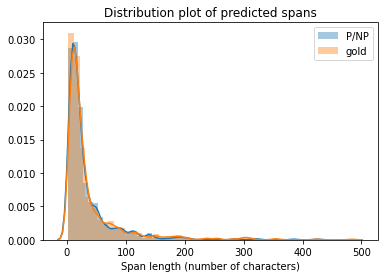

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_lengths(spans):
  span_lengths = []
  s2 = []
  for sp in spans:
    for s in sp:
      if s[1] - s[0] < 500:
        span_lengths.append(s[1] - s[0])
  return span_lengths

lengths1 = get_lengths(spans1)
lengths2 = get_lengths(spans2)
lengths_gold = get_lengths(gold_spans)
# sns.distplot(lengths1, label="BIOE")
sns.distplot(lengths2, label="P/NP")
sns.distplot(lengths_gold, label="gold")
plt.xlabel("Span length (number of characters)")
plt.title("Distribution plot of predicted spans")
plt.legend()
plt.savefig('span_length.png')

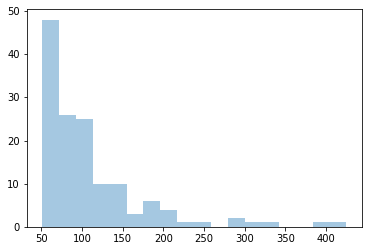

In [ ]:
sns.distplot(lengths2, kde=False, label="P/NP")

In [ ]:
print(np.mean(lengths1))
print(np.mean(lengths2))
print(np.mean(lengths_gold))

35.895814781834375
33.24125
37.73936170212766
